In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances

import utils.sulfur.constant as const
from context_data_csv import ContextDataCSV
from matrix_optimizer import MatrixOptimizer

In [2]:
def create_columns(ref_ctx, cmp_ctx):
    column_df = pd.DataFrame()
    column_df['cell type'] = ['engram', 'engram', 'non-engram', 'non-engram']
    column_df['context'] = [ref_ctx, cmp_ctx] * 2
    return pd.MultiIndex.from_frame(column_df)

def split_engram_matrix(animal_name, context_name):
    csv = ContextDataCSV(animal_name, context_name)
    matrix = csv.data_frame
    matrix = MatrixOptimizer(matrix).divide_sd()
    
    engram_df = matrix.loc[:, csv.engram_cells()]
    non_engram_df = matrix.loc[:, csv.non_engram_cells()]
    
    return engram_df, non_engram_df

def droped_unique_cells(cells1, cells2):
    droped_cells = np.array([])
    droped_cells = np.append(droped_cells, cells1)
    droped_cells = np.append(droped_cells, cells2)
    droped_cells = np.unique(droped_cells)
    return droped_cells

def all_nan_cells(matrix):
    nan_cells = np.array([])
    for cell_name, items in matrix.iteritems():
        if items.isnull().all():
            nan_cells = np.append(nan_cells, cell_name)
            
    return nan_cells

In [3]:
def init_pairwise_distance_df(ref_ctx, cmp_ctx):
    index = const.ANIMAL_NAMES
    columns = create_columns(ref_ctx, cmp_ctx)
    across_session_df = pd.DataFrame(0.0, columns=columns, index=index)
    inner_session_df = pd.DataFrame(0.0, columns=columns, index=index)
    
    return across_session_df, inner_session_df

def calc_pairwise_distance(ref_ctx, cmp_ctx, ref_frames, cmp_frames):
    across_session_df, inner_session_df = init_pairwise_distance_df(ref_ctx, cmp_ctx)
    
    for animal_name in const.ANIMAL_NAMES:
        # ref context
        ref_engram_df, ref_non_engram_df = split_engram_matrix(animal_name, ref_ctx)
        
        ref_nan_engram_cells = all_nan_cells(ref_engram_df)
        ref_nan_non_engram_cells = all_nan_cells(ref_non_engram_df)
        
        # cmp context
        cmp_engram_df, cmp_non_engram_df = split_engram_matrix(animal_name, cmp_ctx)
        
        cmp_nan_engram_cells = all_nan_cells(cmp_engram_df)
        cmp_nan_non_engram_cells = all_nan_cells(cmp_non_engram_df)
        
        # fetch dropped cells
        dropped_engram_cells = droped_unique_cells(ref_nan_engram_cells, cmp_nan_engram_cells)
        dropped_non_engram_cells = droped_unique_cells(ref_nan_non_engram_cells, cmp_nan_non_engram_cells)
        
        # ref context
        ref_engram_df.drop(columns=dropped_engram_cells, inplace=True)
        ref_non_engram_df.drop(columns=dropped_non_engram_cells, inplace=True)
        
        ref_engram_df = ref_engram_df.iloc[ref_frames[0]:ref_frames[1], :]
        ref_non_engram_df = ref_non_engram_df.iloc[ref_frames[0]:ref_frames[1], :]
        
        # cmp context
        cmp_engram_df.drop(columns=dropped_engram_cells, inplace=True)
        cmp_non_engram_df.drop(columns=dropped_non_engram_cells, inplace=True)
        
        cmp_engram_df = cmp_engram_df.iloc[cmp_frames[0]:cmp_frames[1], :]
        cmp_non_engram_df = cmp_non_engram_df.iloc[cmp_frames[0]:cmp_frames[1], :]
        
        across_session_df.loc[animal_name, ('engram', ref_ctx)] = np.mean(pairwise_distances(ref_engram_df, ref_engram_df))
        across_session_df.loc[animal_name, ('engram', cmp_ctx)] = np.mean(pairwise_distances(ref_engram_df, cmp_engram_df))
        
        across_session_df.loc[animal_name, ('non-engram', ref_ctx)] = np.mean(pairwise_distances(ref_non_engram_df, ref_non_engram_df))
        across_session_df.loc[animal_name, ('non-engram', cmp_ctx)] = np.mean(pairwise_distances(ref_non_engram_df, cmp_non_engram_df))
        
        inner_session_df.loc[animal_name, ('engram', ref_ctx)] = np.mean(pairwise_distances(ref_engram_df, ref_engram_df))
        inner_session_df.loc[animal_name, ('engram', cmp_ctx)] = np.mean(pairwise_distances(cmp_engram_df, cmp_engram_df))
        
        inner_session_df.loc[animal_name, ('non-engram', ref_ctx)] = np.mean(pairwise_distances(ref_non_engram_df, ref_non_engram_df))
        inner_session_df.loc[animal_name, ('non-engram', cmp_ctx)] = np.mean(pairwise_distances(cmp_non_engram_df, cmp_non_engram_df))
        
    return across_session_df, inner_session_df
    
def view_pairwise_distance_bar(across_session_df, inner_session_df, ref_ctx, cmp_ctx):
    engram_across_df = across_session_df.iloc[:, 0:2]
    non_engram_across_df = across_session_df.iloc[:, 2:]
    
    engram_inner_df = inner_session_df.iloc[:, 0:2]
    non_engram_inner_df = inner_session_df.iloc[:, 2:]
    
    base_session_color = 'lightsteelblue'
    
    xticklabels = [ref_ctx, cmp_ctx, '%s v.s %s' % (ref_ctx, cmp_ctx)]
    
    fig, axes = plt.subplots(ncols=2, figsize=(20, 10), dpi=200)
    axes[0].set_title('engram', fontsize=20)
    axes[0].bar(x=0, height=engram_inner_df.iloc[:, 0].mean(), yerr=engram_inner_df.iloc[:, 0].sem(), capsize=8, align='center',color=base_session_color)
    axes[0].bar(x=1, height=engram_inner_df.iloc[:, 1].mean(), yerr=engram_inner_df.iloc[:, 1].sem(), capsize=8, align='center',color='indianred')
    axes[0].bar(x=2, height=engram_across_df.iloc[:, 1].mean(), yerr=engram_across_df.iloc[:, 1].sem(), capsize=8, align='center',color=base_session_color, linewidth=10, edgecolor='indianred')
    axes[0].set_xticks([0, 1, 2])
    axes[0].set_xticklabels(xticklabels, rotation=45, fontsize=20)
    axes[0].tick_params(axis='y', labelsize=20)
    
    axes[1].set_title('non-engram', fontsize=20)
    axes[1].bar(x=0, height=non_engram_inner_df.iloc[:, 0].mean(), yerr=non_engram_inner_df.iloc[:, 0].sem(), capsize=8, align='center',color=base_session_color)
    axes[1].bar(x=1, height=non_engram_inner_df.iloc[:, 1].mean(), yerr=non_engram_inner_df.iloc[:, 1].sem(), capsize=8, align='center',color='navy')
    axes[1].bar(x=2, height=non_engram_across_df.iloc[:, 1].mean(), yerr=non_engram_across_df.iloc[:, 1].sem(), capsize=8, align='center',color=base_session_color, linewidth=10, edgecolor='navy')
    axes[1].set_xticks([0, 1, 2])
    axes[1].set_xticklabels(xticklabels, rotation=45, fontsize=20)
    axes[1].tick_params(axis='y', labelsize=20)
    
    fig.tight_layout()
    fig.show()

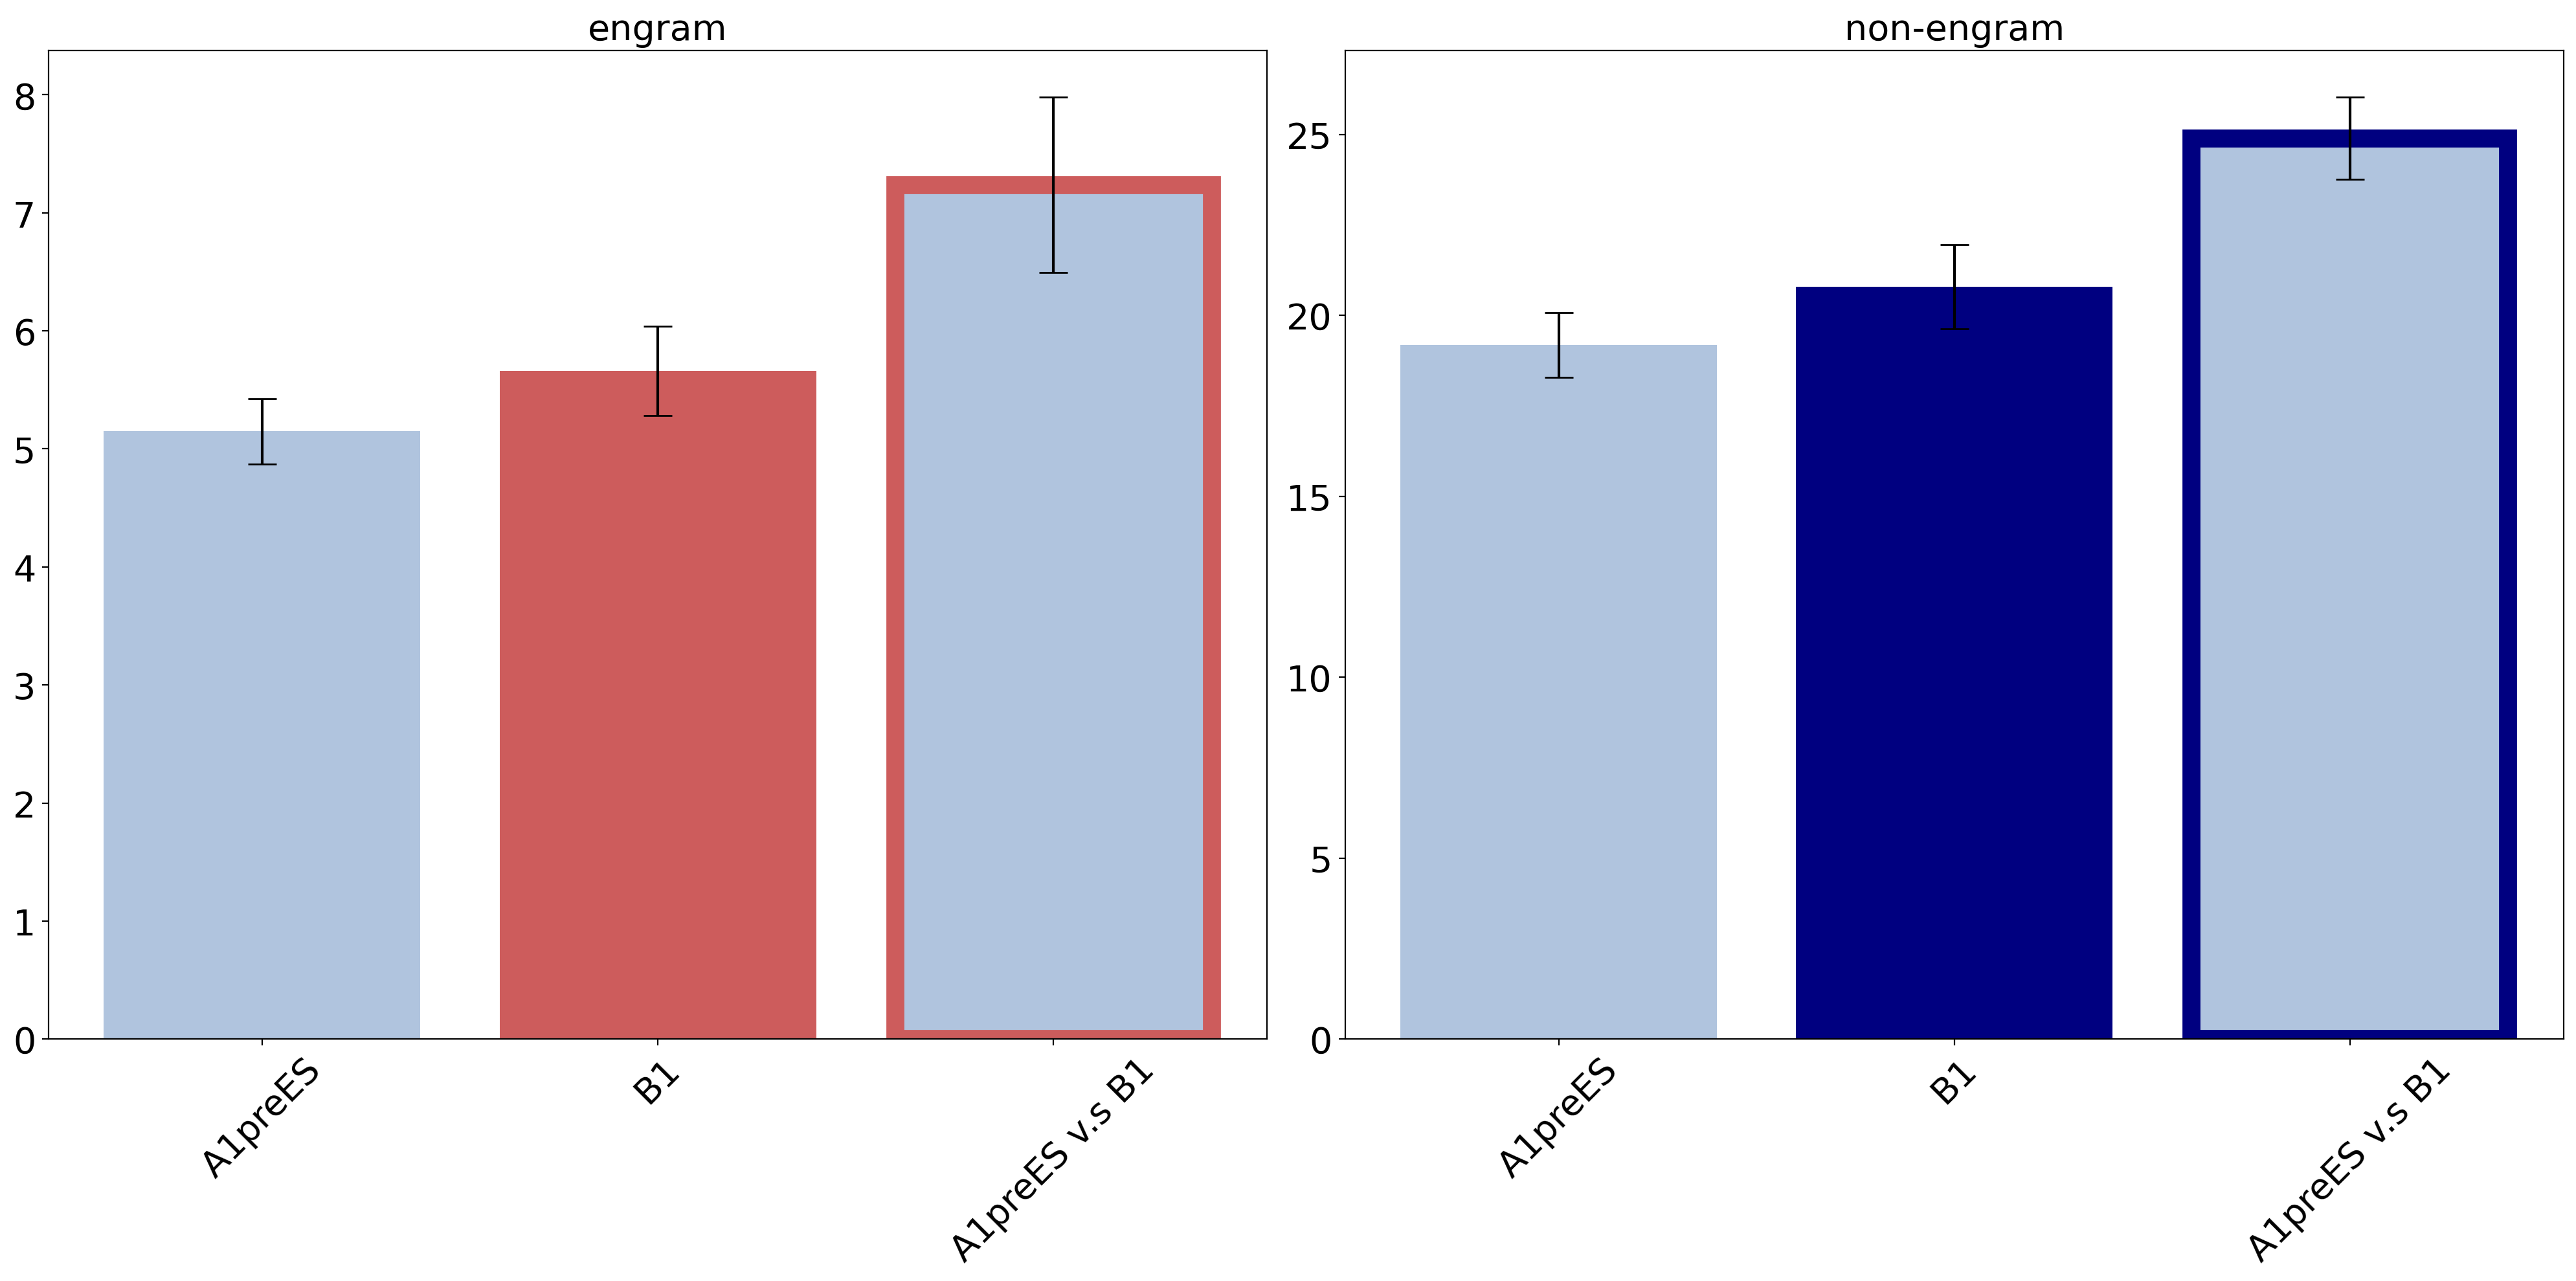

In [4]:
ref_ctx = 'A1preES'
cmp_ctx = 'B1'
across_session_df, inner_session_df = calc_pairwise_distance(ref_ctx, cmp_ctx, ref_frames=[2601, 3001], cmp_frames=[2601, 3001])
view_pairwise_distance_bar(across_session_df, inner_session_df, ref_ctx, cmp_ctx)

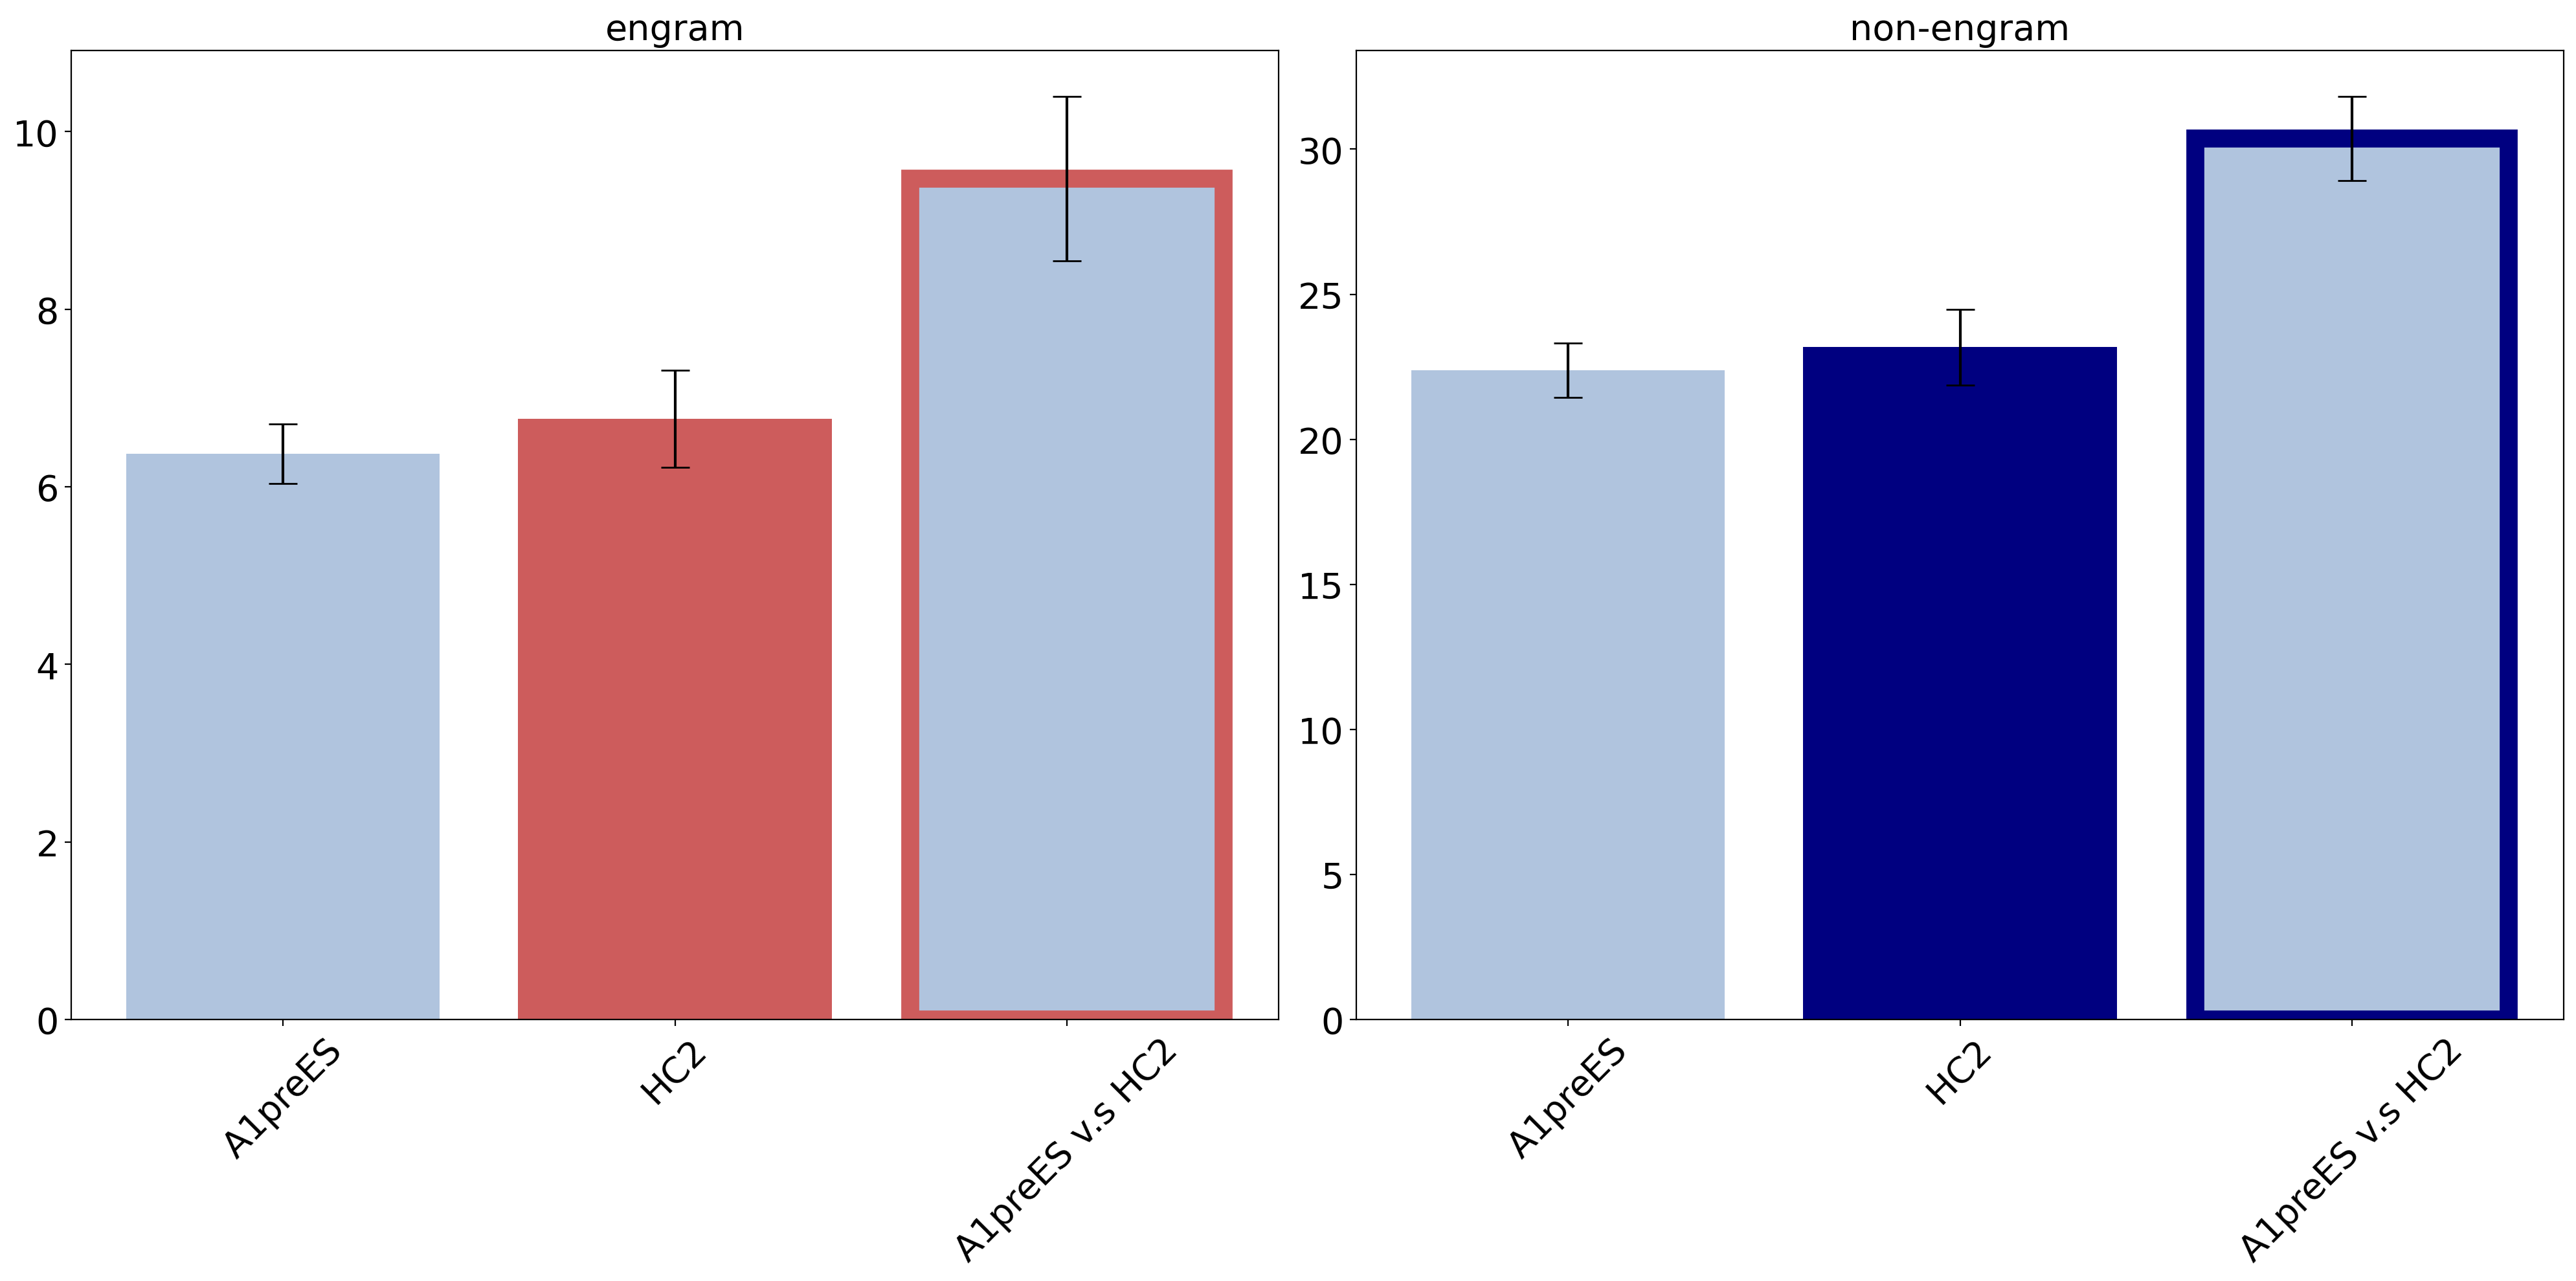

In [5]:
ref_ctx = 'A1preES'
cmp_ctx = 'HC2'
across_session_df, inner_session_df = calc_pairwise_distance(ref_ctx, cmp_ctx, ref_frames=[2601, 3001], cmp_frames=[5601, 6001])
view_pairwise_distance_bar(across_session_df, inner_session_df, ref_ctx, cmp_ctx)